In [31]:
from _utils import wltest_coloring, graph_generator, derive_adjacency,check_symmetric_decomposable,stable_partition
import matplotlib.pyplot as plt 
import networkx as nx 
import torch
import numpy as np
import os
import json


# Load Problem

In [32]:
path = 'MILP/Bin Packing Problem/Bin Packing Problem_[Warehouse Storage Optimization]/model.lp'
A,f,c = graph_generator(path)
Adj = derive_adjacency(A)


The content of lp file ：
```
Minimize
  y[0] + y[1] + y[2]
Subject To
 item_0_placement: x[0,0] + x[0,1] + x[0,2] = 1
 item_1_placement: x[1,0] + x[1,1] + x[1,2] = 1
 item_2_placement: x[2,0] + x[2,1] + x[2,2] = 1
 item_3_placement: x[3,0] + x[3,1] + x[3,2] = 1
 item_4_placement: x[4,0] + x[4,1] + x[4,2] = 1
 bin_0_capacity: 8.6600389009 x[0,0] + 9.0341843686 x[1,0]
   + 1.7299075019 x[2,0] + 0.1213382457 x[3,0] + 3.9651754001 x[4,0]
   - 4.8654483379 y[0] <= 0
 bin_1_capacity: 8.6600389009 x[0,1] + 9.0341843686 x[1,1]
   + 1.7299075019 x[2,1] + 0.1213382457 x[3,1] + 3.9651754001 x[4,1]
   - 4.8654483379 y[1] <= 0
 bin_2_capacity: 8.6600389009 x[0,2] + 9.0341843686 x[1,2]
   + 1.7299075019 x[2,2] + 0.1213382457 x[3,2] + 3.9651754001 x[4,2]
   - 4.8654483379 y[2] <= 0
Bounds
Binaries
 x[0,0] x[0,1] x[0,2] x[1,0] x[1,1] x[1,2] x[2,0] x[2,1] x[2,2] x[3,0]
 x[3,1] x[3,2] x[4,0] x[4,1] x[4,2] y[0] y[1] y[2]
End

```

There are in total 18 variables and 8 constraints. To avoid ambiguity of bipartite graph representation, we represent the boundary of variables as some constraint nodes. 

Therefore, there should be in total 18+8+2*18 = 62 constraints. The dimension of adjacency matrix should be (62+18) * (62+18), i.e. 80 * 80

# Visualize the bipartite graph

In [33]:
# Helper functions
def generate_graph(A1,c1,f1):
    G = nx.DiGraph()
    list_x =[]
    list_c =[]
    for i in range(len(f1)):
        G.add_node(f'x_{i}', bipartite=0)  # Variable set
        list_x.append(f'x_{i}')
    for j in range(len(c1)):
        G.add_node(f'c_{j}', bipartite=1)  # Constraint set
        list_c.append(f'c_{j}')

    for i in range(len(f1)):
        for j in range(len(c1)):
            if A1[j][i] !=0:
                G.add_edge(f'x_{i}', f'c_{j}')
                
    return G,list_x,list_c

def get_color_list(color_map,G):
    color_list = []
    for node in G.nodes:
        color_list.append(color_map[node])
    return color_list

def produce_wl_color_map(color,color_cons,color_var,G):
    len_color_list = len(color[0])
    import distinctipy
    def generate_color_list(length):
        return distinctipy.get_colors(length)
    color_list = generate_color_list(len_color_list)
    color_map = {}
    color_x = []
    for node in G.nodes:
        if 'x' in node:
            node_index = int(node.split('_')[1])
            color_map[node] = color_list[torch.argmax(color_var[node_index]).item()]
            color_x.append(color_list[torch.argmax(color_var[node_index]).item()])
    for node in G.nodes:
        if 'c' in node:
            indent = len(set(color_x))
            node_index = int(node.split('_')[1])
            color_map[node] = color_list[indent+torch.argmax(color_cons[node_index]).item()]        
    return color_map


In [34]:
G,list_x,list_c = generate_graph(A,c,f)
color,color_cons,color_var = wltest_coloring(c,f,A)
color_map = produce_wl_color_map(color,color_cons,color_var,G)
same_color_partition_var = stable_partition(color_var)
same_color_partition_cons = stable_partition(color_cons)
unique_set_var = [v[0] for k, v in same_color_partition_var.items() if len(v) == 1]
unique_set_cons = [v[0] for k, v in same_color_partition_cons.items() if len(v) == 1]

# Remove nodes with degree 0, and nodes that are uniquely colored
nodes_to_remove1 = [node for node, degree in G.degree() if degree == 0]
nodes_to_remove2 = [f'c_{i}' for i in unique_set_cons]
nodes_to_remove3 = [f'x_{i}' for i in unique_set_var]
nodes_to_remove = nodes_to_remove1+nodes_to_remove2+nodes_to_remove3

print('nodes_to_remove:',nodes_to_remove)
G.remove_nodes_from(nodes_to_remove)

color_list = get_color_list(color_map,G)

nodes_to_remove: ['c_0', 'c_1', 'c_2', 'c_3', 'c_4']


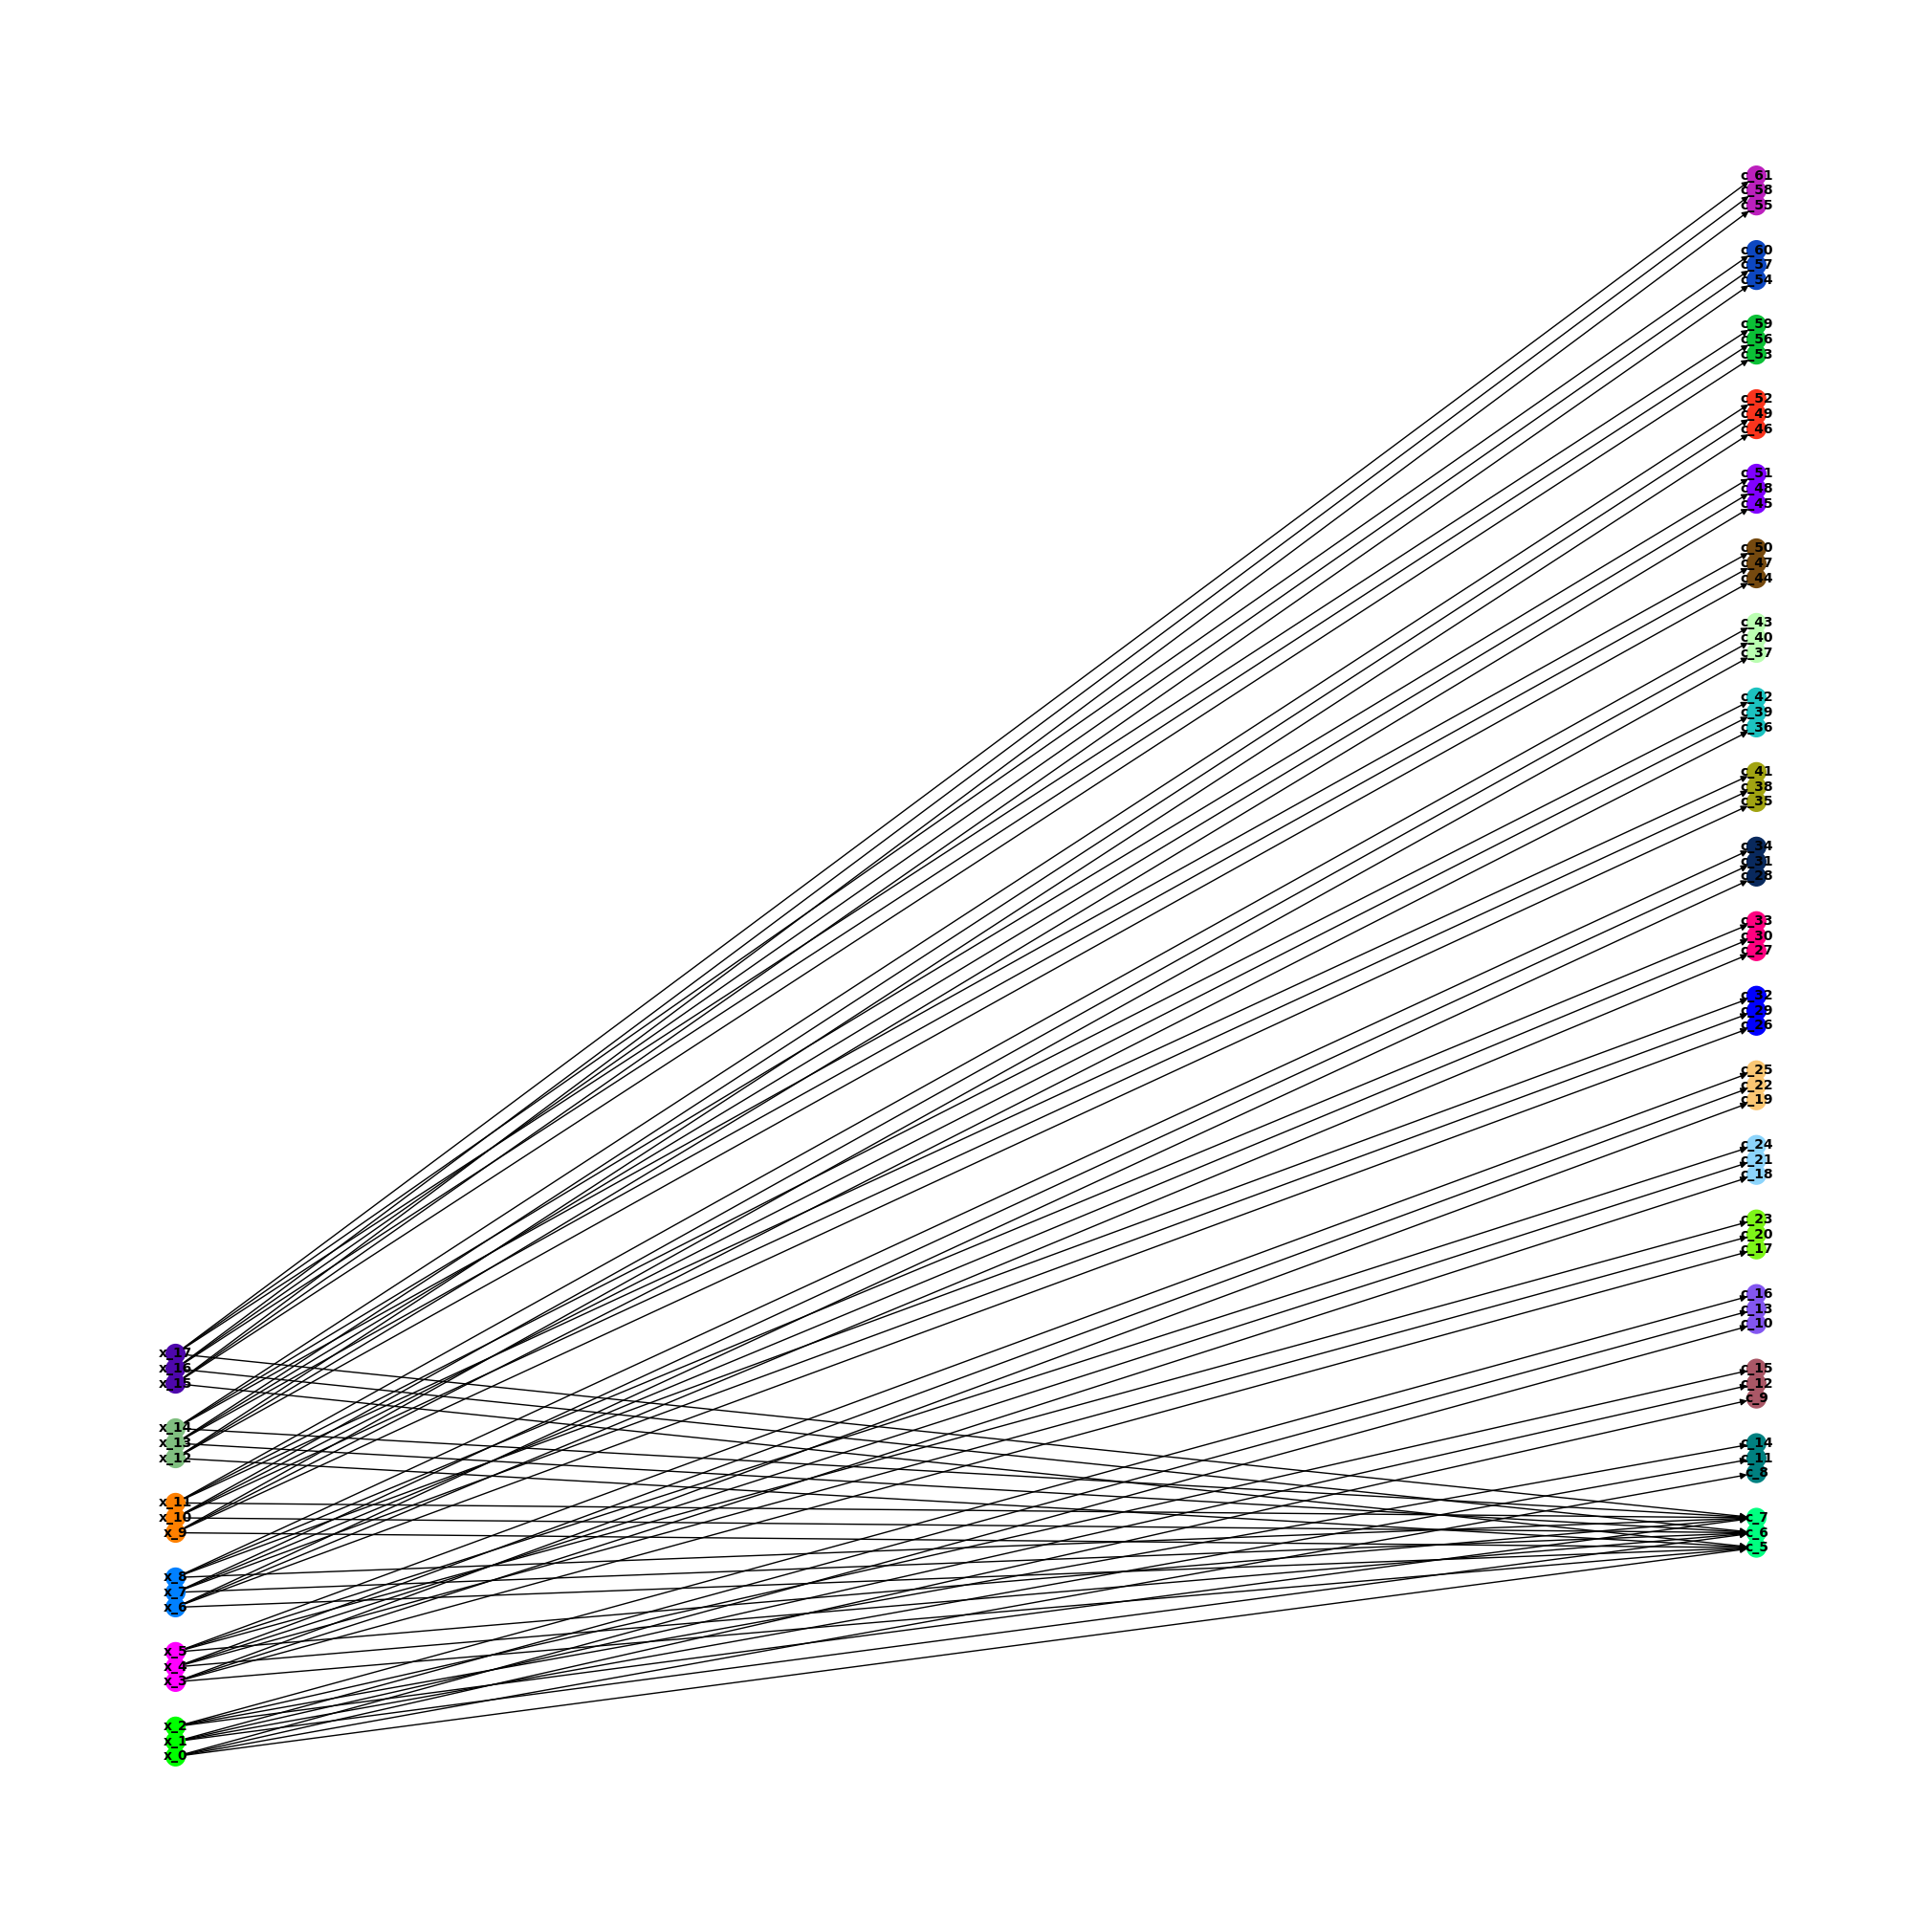

{(0.0, 1.0, 0.0): ['x_0', 'x_1', 'x_2'], (1.0, 0.0, 1.0): ['x_3', 'x_4', 'x_5'], (0.0, 0.5, 1.0): ['x_6', 'x_7', 'x_8'], (1.0, 0.5, 0.0): ['x_9', 'x_10', 'x_11'], (0.5, 0.75, 0.5): ['x_12', 'x_13', 'x_14'], (0.30594274267361987, 0.028561178034243517, 0.6745285305550309): ['x_15', 'x_16', 'x_17'], (0.0, 1.0, 0.5): ['c_5', 'c_6', 'c_7'], (0.0, 0.5, 0.5): ['c_8', 'c_11', 'c_14'], (0.6649958874496447, 0.3394524944807471, 0.40160919959716346): ['c_9', 'c_12', 'c_15'], (0.5123123015943527, 0.3370661200744376, 0.9415054963679756): ['c_10', 'c_13', 'c_16'], (0.4912395361801041, 0.9564418828890636, 0.09450702514054721): ['c_17', 'c_20', 'c_23'], (0.5482505617773004, 0.8325286593265896, 0.9826871169124298): ['c_18', 'c_21', 'c_24'], (0.9822935329214928, 0.7781207855066686, 0.4519211411169548): ['c_19', 'c_22', 'c_25'], (0.0, 0.0, 1.0): ['c_26', 'c_29', 'c_32'], (1.0, 0.0, 0.5): ['c_27', 'c_30', 'c_33'], (0.0347368998161236, 0.15956577724418297, 0.36318725170371924): ['c_28', 'c_31', 'c_34'], (0.

In [35]:
pos = nx.bipartite_layout(G,list_x)  # Nodes from Set 1 on the left

color_groups = {}  # Group nodes by color
for node, color_ in color_map.items():
    if node in G.nodes():
        if color_ not in color_groups :
            color_groups[color_] = []
        color_groups[color_].append(node)

for key in pos:
    pos[key][1] *= 25 

count = 0
for color_ in color_groups:
    y_offset = count
    variation = 0
    for node in color_groups[color_]:
        pos[node][1] = y_offset+variation
        variation += 0.5
    count += 2.5

for node in list_c:
    if node in G.nodes():
        pos[node][0] = pos[node][0] -0.5
        pos[node][1] = pos[node][1] -8
plt.figure(figsize=(20, 20))
nx.draw(G, pos, with_labels=True, node_size=200, node_color=color_list, font_size=10,font_weight='bold')

plt.show()

print(color_groups)


According to the visualized graph, this problem is symmetric decomposable as its bipartite graph can be decomposed to 3 clusters that disjoint with each other, nodes within each have distinct colors, and the coloring set for each cluster is the same.

In [36]:
# use our algorithm to check if the graph is symmetric decomposable

check_symmetric_decomposable(color,Adj)

(True, 'Symmetric Decomposable.')